In [771]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt

In [796]:
def plot(df,name):
    # Your data
    column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
    
    column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']
    plt.figure(figsize=(14,14))

    plt.subplot(2, 2, 1)

    plt.title(name)
    x=range(0,len(column_name_probability))
    
    plt.bar(x=x,height=df[column_name_probability].mean(),alpha=0.3)
    plt.errorbar(x,df[column_name_probability].mean(),yerr=df[column_name_probability].std(), fmt='o')
    #.plot(kind='bar', width=0.8) # Plot bar chart
    #plt.title("ksad") # Set title as column name
    #plt.xlabel(column) # Set x-axis label as column name
    plt.xticks(ticks=x,labels=column_name_probability_labels,rotation=90-15,fontsize=8)
    #plt.xticks(ticks=range(0,len(column_name)),labels=column,rotation=45)
    plt.ylabel('Value') # Set y-axis label as 'Value'
    column_name=["SocketPower0", "SocketPower1","PSUPower0","PSUPower1"]
    plt.subplot(2, 2, 2)
    plt.title("System power")
    _ = plt.plot(df[column_name],label=column_name)
    plt.ylim([0,700])
    plt.legend()
    plt.subplot(2, 2, 3)
    filtered_df = df[column_name_probability].loc[:, df[column_name_probability].mean() > 0]
    plt.plot(filtered_df,label=filtered_df.columns.tolist())
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.title("System usage")
    plt.plot(df[["SystemCpuUsage" ,"ProcessCpuUsage"]],label=["SystemCpuUsage" ,"ProcessCpuUsage"])
    plt.legend()
    plt.savefig(f"{name}.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Opened file: power_copy.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Opened file: power_copy_mem.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Opened file: power_copy_mem_avx.csv


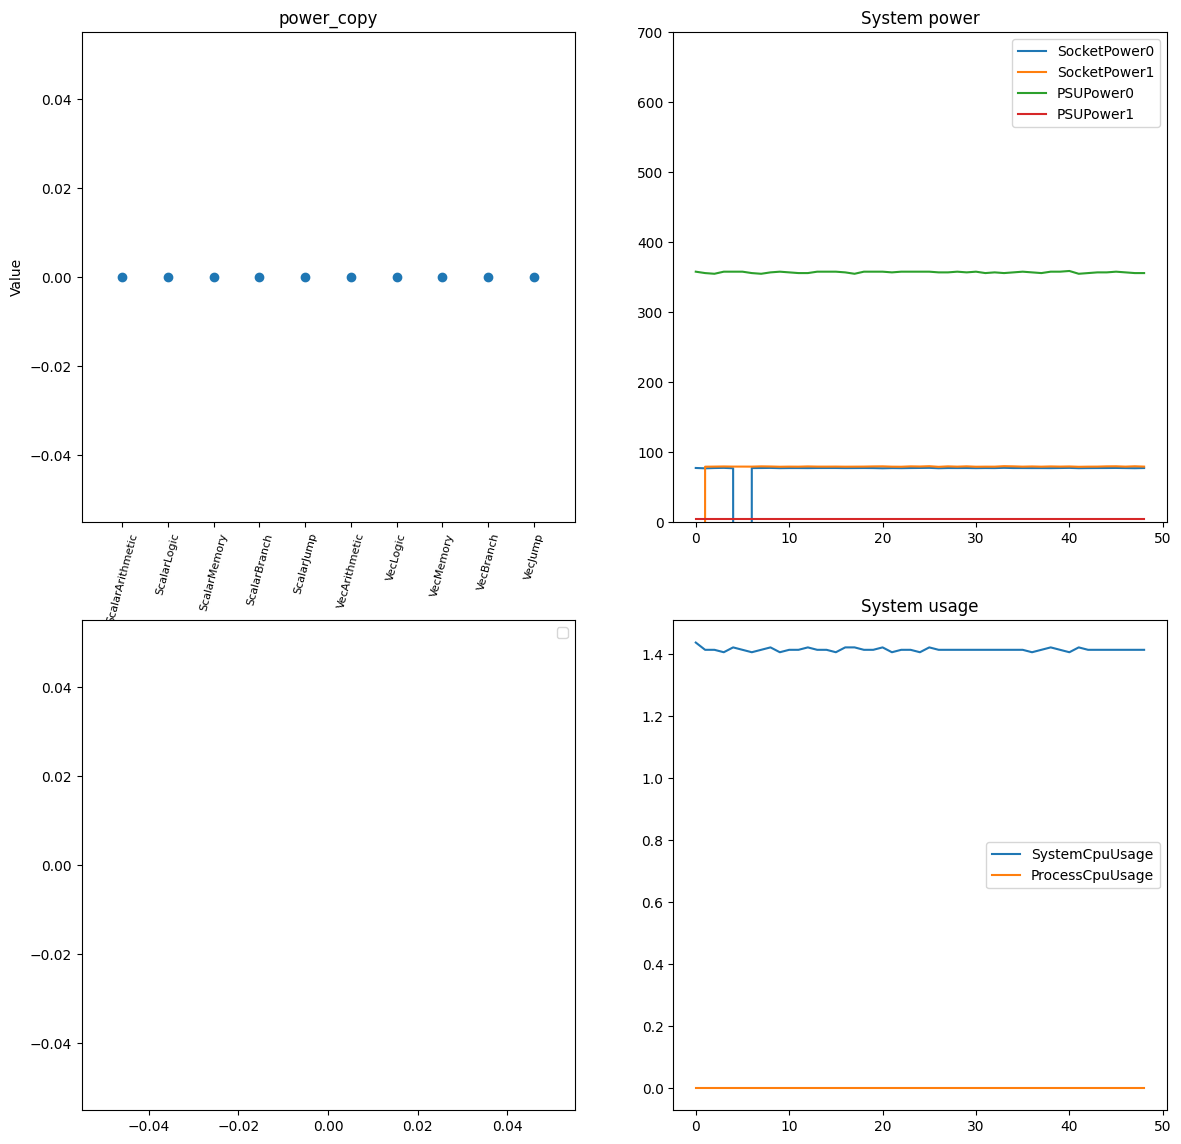

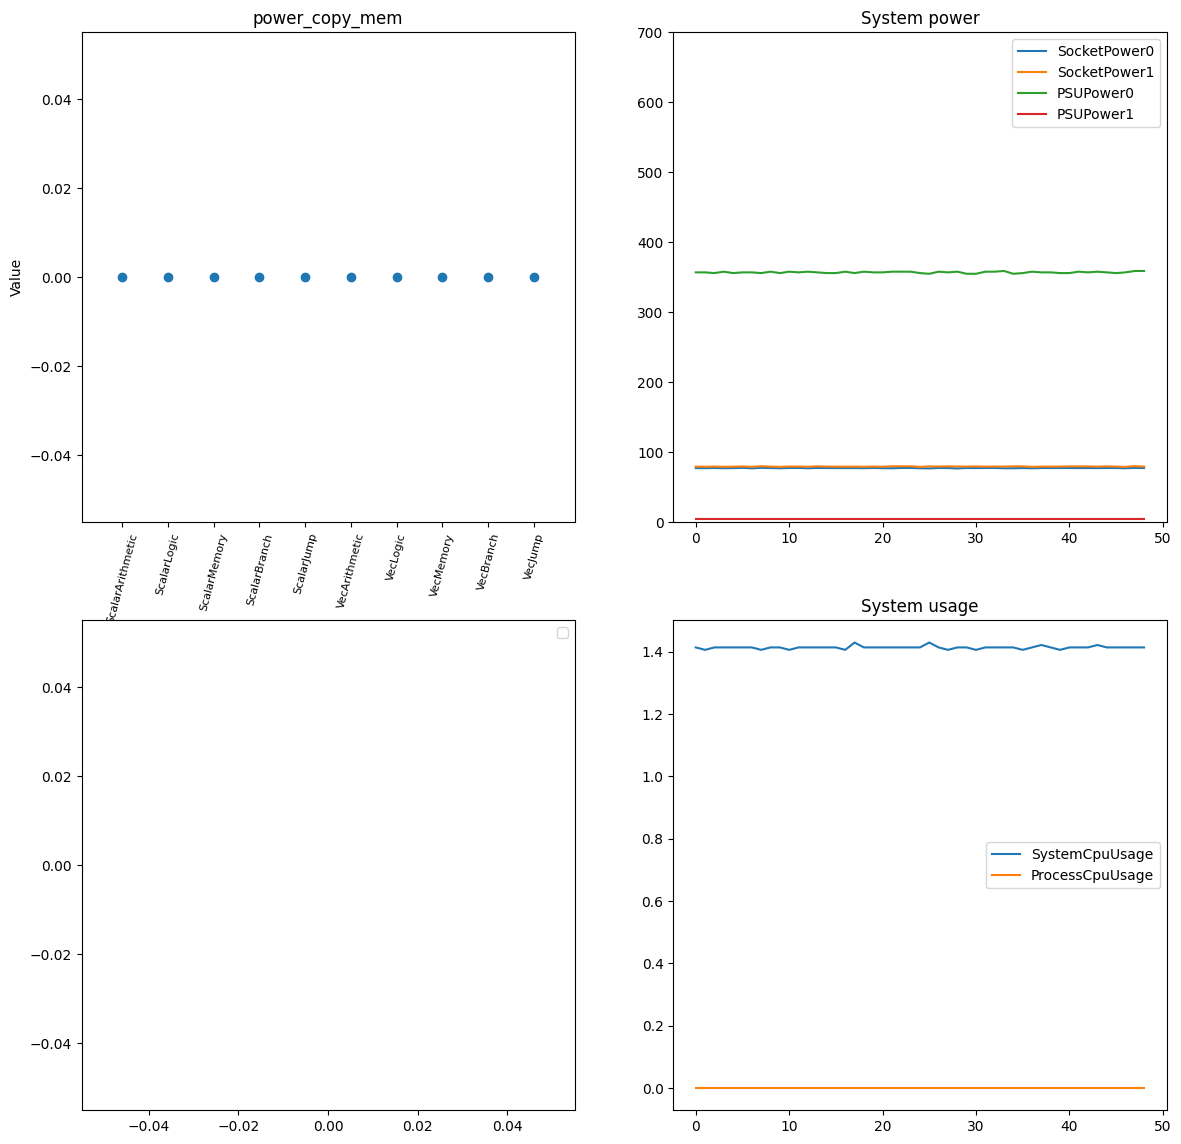

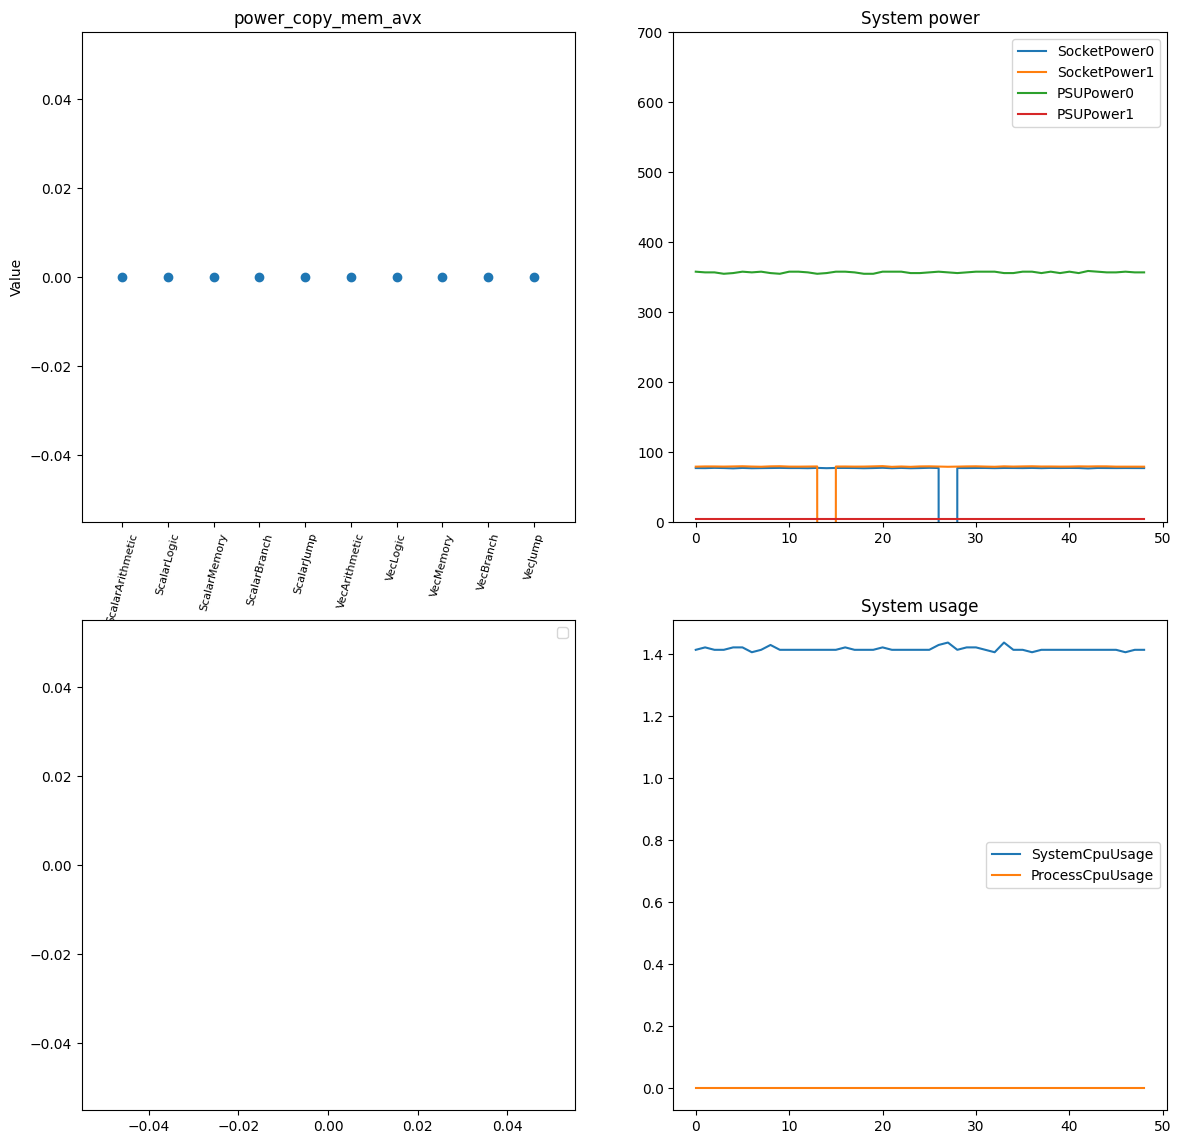

In [798]:
directory_list=["results_sleep"]

df_list=list()
for directory in directory_list:
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            try:
                df = pd.read_csv(os.path.join(directory, filename))
                df_list.append(df)
                print(f"Opened file: {filename}")
                #print(df.head())  # prints the first 5 rows of each CSV file
                plot(df,os.path.basename(filename).split(".")[0])
            except Exception as e:
                print(e)

In [727]:
df = pd.concat(df_list)

In [728]:
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]

In [729]:
import numpy as np
from scipy.optimize import nnls

# naive model

In [730]:
independent_variables=[ #"SocketPower0","SocketPower1",
                        "ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump",	"SystemCpuUsage"]#, 	"ProcessCpuUsage"]

In [731]:
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]

In [732]:
A=df[independent_variables].to_numpy()
b=np.ones((A.shape[0],1))
A=np.hstack((A,b))

coeff,error=nnls(A, df["Total_power"].to_numpy())
intercept=coeff[-1]

print(f"Residual {error}, intercept {intercept}")

Residual 1731.54433302371, intercept 411.20844303460785


Text(0.5, 0, 'Predicted value')

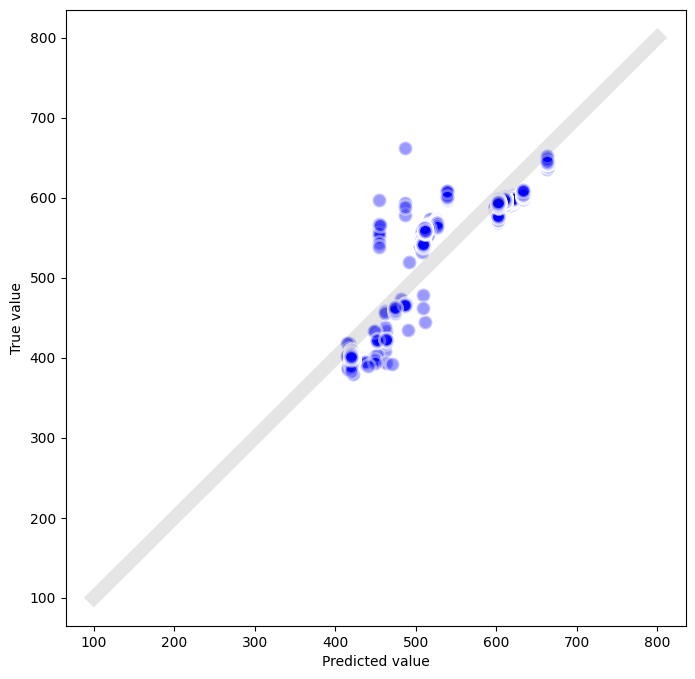

In [733]:
prediction=list()
for row in df[independent_variables].to_numpy():
    prediction.append(row@coeff[:-1] + intercept)

plt.figure(figsize=(8,8))
plt.plot(prediction,df["Total_power"], 'bo', 
         markersize=10, 
         alpha=0.4,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("True value")
plt.xlabel("Predicted value")

Text(0.5, 0, 'Socket power predicted')

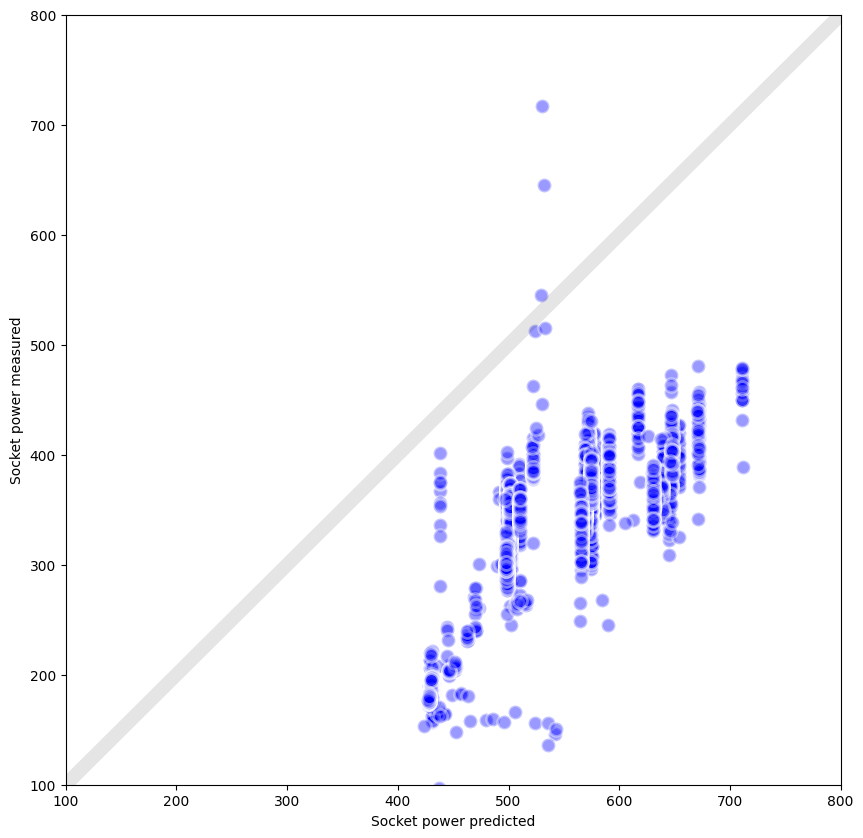

In [804]:
prediction=list()
for row in df[independent_variables].to_numpy():
    prediction.append(row@coeff[:-1] + intercept)

plt.figure(figsize=(10,10))
plt.plot(prediction,df["SocketPower0"]+df["SocketPower1"], 'bo', 
         markersize=10, 
         alpha=0.4,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylim([100,800])
plt.xlim([100,800])
plt.ylabel("Socket power measured")
plt.xlabel("Socket power predicted")

# Smarter model, paper model

In [865]:
def normalize(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    df[percentages]=df[percentages]/100
    df["SystemCpuUsage"]=df["SystemCpuUsage"]/128
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]/128
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"]
    TDP=280

    for var in independent_variables:
        df[var]=df[var]*df["SystemCpuUsage"]*df["Total_socket"]#*TDP*2
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    
    return df

In [874]:
def load_df_list_train():
    directory_list=["results_32","results_64","results_fan","results_96","results_128","results_sleep"]
    #directory_list=["results_96"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    df_list.append(df)
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_list_test():
    directory_list=["results_32","results_64","results_fan","results_96","results_sleep"]
    
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    df_list.append(df)
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list


In [875]:
independent_variables=[ "ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df = normalize(df)

In [876]:
A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff,error=nnls(A, df["Total_power"].to_numpy(), maxiter=1000,atol=max(A.shape) * np.linalg.norm(A, 1) * np.spacing(1.))
intercept=coeff[-1]
print(f"Residual {error}, intercept {intercept}")
#print(coeff)

for name,value in zip(independent_variables,coeff):
    print(name,value)

Residual 3268.900151209503, intercept 420.6219974872897
ProbabilityScalarArithmetic 1.2882708569307006
ProbabilityScalarLogic 0.8988404245336288
ProbabilityScalarMemory 1.0078410014096877
ProbabilityScalarBranch 0.0
ProbabilityScalarJump 0.0
ProbabilityVectorArithmetic 1.1248925260759903
ProbabilityVectorLogic 0.0
ProbabilityVectorMemory 0.9836745099891739
ProbabilityVectorBranch 0.0
ProbabilityVectorJump 0.0


Text(0.5, 0, 'Predicted value')

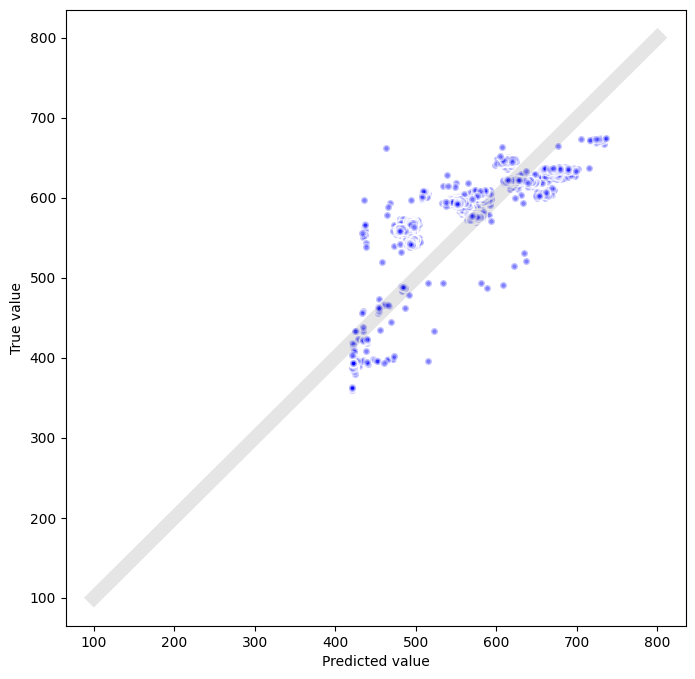

In [877]:
df_list_test= load_df_list_test()
df = pd.concat(df_list_test)
df = normalize(df)
prediction=list()

for row in df[independent_variables].to_numpy():
    prediction.append(row@coeff[:-1] + intercept)

plt.figure(figsize=(8,8))
plt.plot(prediction,df["Total_power"], 'bo', 
         markersize=5, 
         alpha=0.5,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("True value")
plt.xlabel("Predicted value")

Text(0.5, 0, 'Socket power predicted')

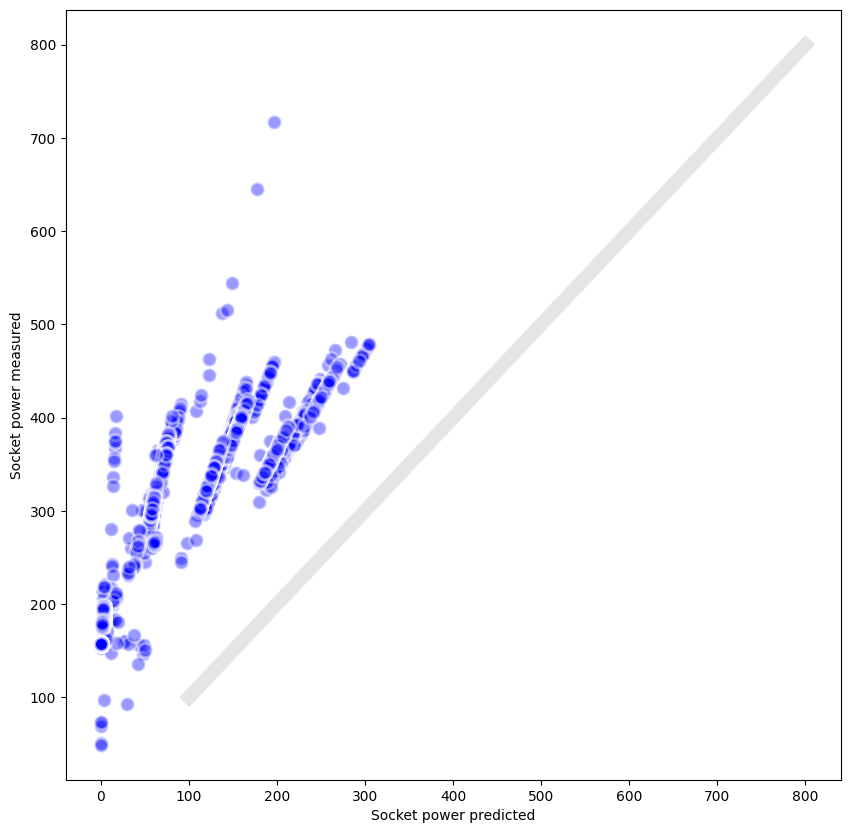

In [849]:
prediction=list()

for row in df[independent_variables].to_numpy():
    prediction.append(row@coeff[:-1])

plt.figure(figsize=(10,10))
plt.plot(prediction,df["SocketPower0"]+df["SocketPower1"], 'bo', 
         markersize=10, 
         alpha=0.4,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("Socket power measured")
plt.xlabel("Socket power predicted")

In [841]:
def plot(df,name,coeff):
    intercept=coeff[-1]
    coeff=coeff[:-1]
    
    # Your data
    column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
    
    column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']
    
    plt.figure(figsize=(14,14))

    plt.subplot(2, 2, 1)

    plt.title(name)
    x=range(0,len(column_name_probability))
    
    plt.bar(x=x,height=df[column_name_probability].mean(),alpha=0.3)
    plt.errorbar(x,df[column_name_probability].mean(),yerr=df[column_name_probability].std(), fmt='o')
    #.plot(kind='bar', width=0.8) # Plot bar chart
    #plt.title("ksad") # Set title as column name
    #plt.xlabel(column) # Set x-axis label as column name
    plt.xticks(ticks=x,labels=column_name_probability_labels,rotation=90-15,fontsize=8)
    #plt.xticks(ticks=range(0,len(column_name)),labels=column,rotation=45)
    plt.ylabel('Value') # Set y-axis label as 'Value'
    column_name=["SocketPower0", "SocketPower1","PSUPower0","PSUPower1"]
 #   df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]

    plt.subplot(2, 2, 2)
    plt.title("System power")
    _ = plt.plot(df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ][column_name],label=column_name)
    df=normalize(df)
   
#    x=(df[column_name_probability+["SocketPower0","SocketPower1"]].to_numpy()@coeff)+intercept
    x=(df[column_name_probability].to_numpy()@coeff)+intercept

    _ = plt.plot(x,label="Predicted")
    
    plt.ylim([0,900])
    plt.legend()
    plt.subplot(2, 2, 3)
    filtered_df = df[column_name_probability].loc[:, df[column_name_probability].mean() > 0]
    plt.plot(filtered_df,label=filtered_df.columns.tolist())
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.title("System usage")
    plt.plot(df[["SystemCpuUsage" ,"ProcessCpuUsage"]],label=["SystemCpuUsage" ,"ProcessCpuUsage"])
    plt.legend()
    plt.savefig(f"{name}.png")

Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
Opened file: power_load_avx.csv
Opened file: power_load_mem.csv
Opened file: power_peakflops_avx_fma.csv
Opened file: power_store_mem.csv
Opened file: power_store_mem_avx.csv
Opened file: power_stream_mem_avx_fma.csv
Opened file: power_update_avx.csv


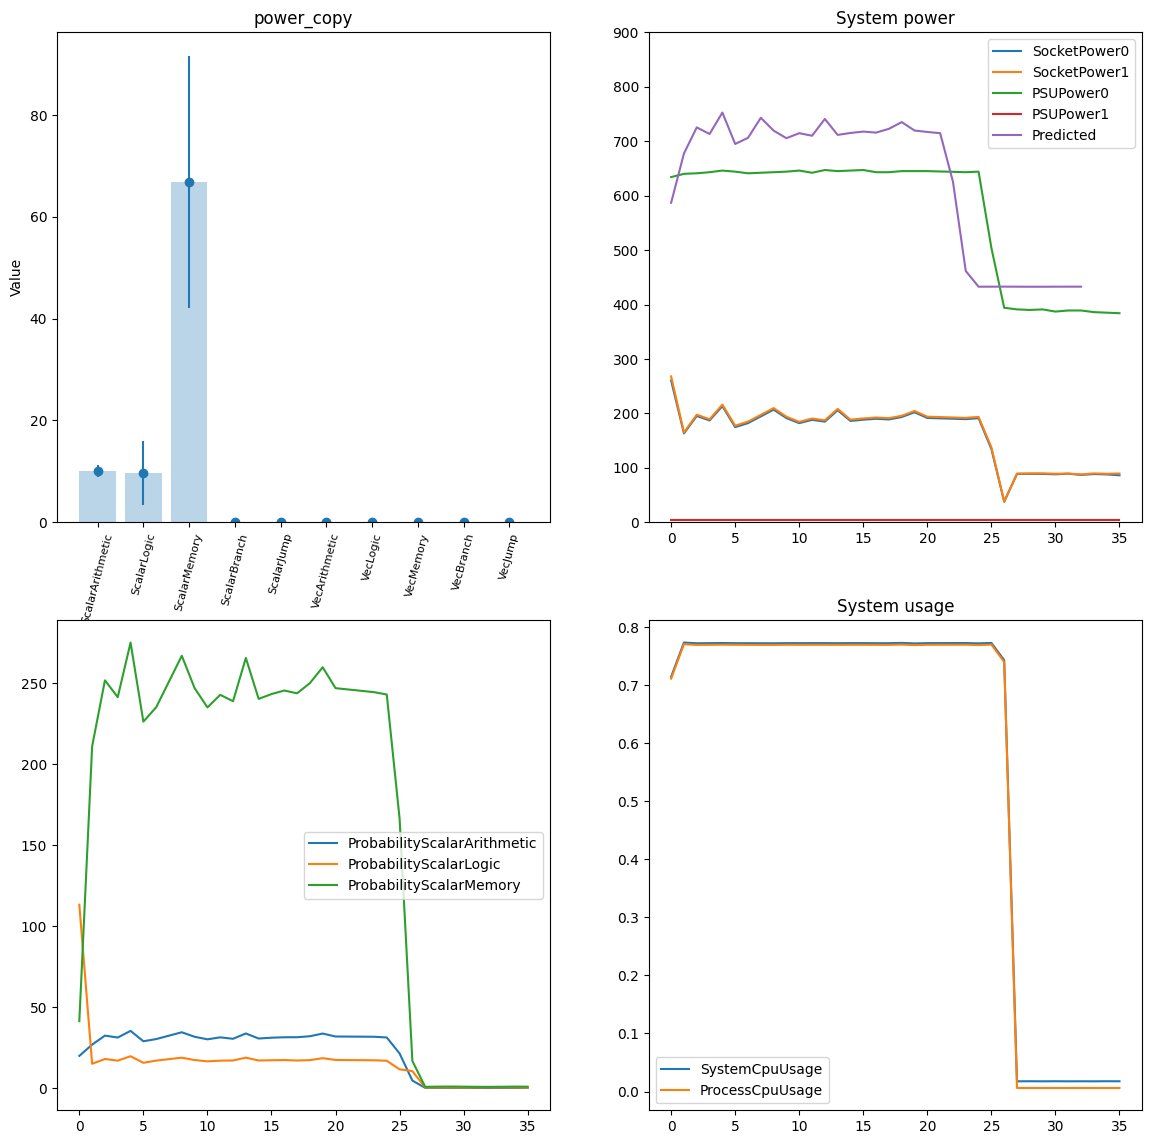

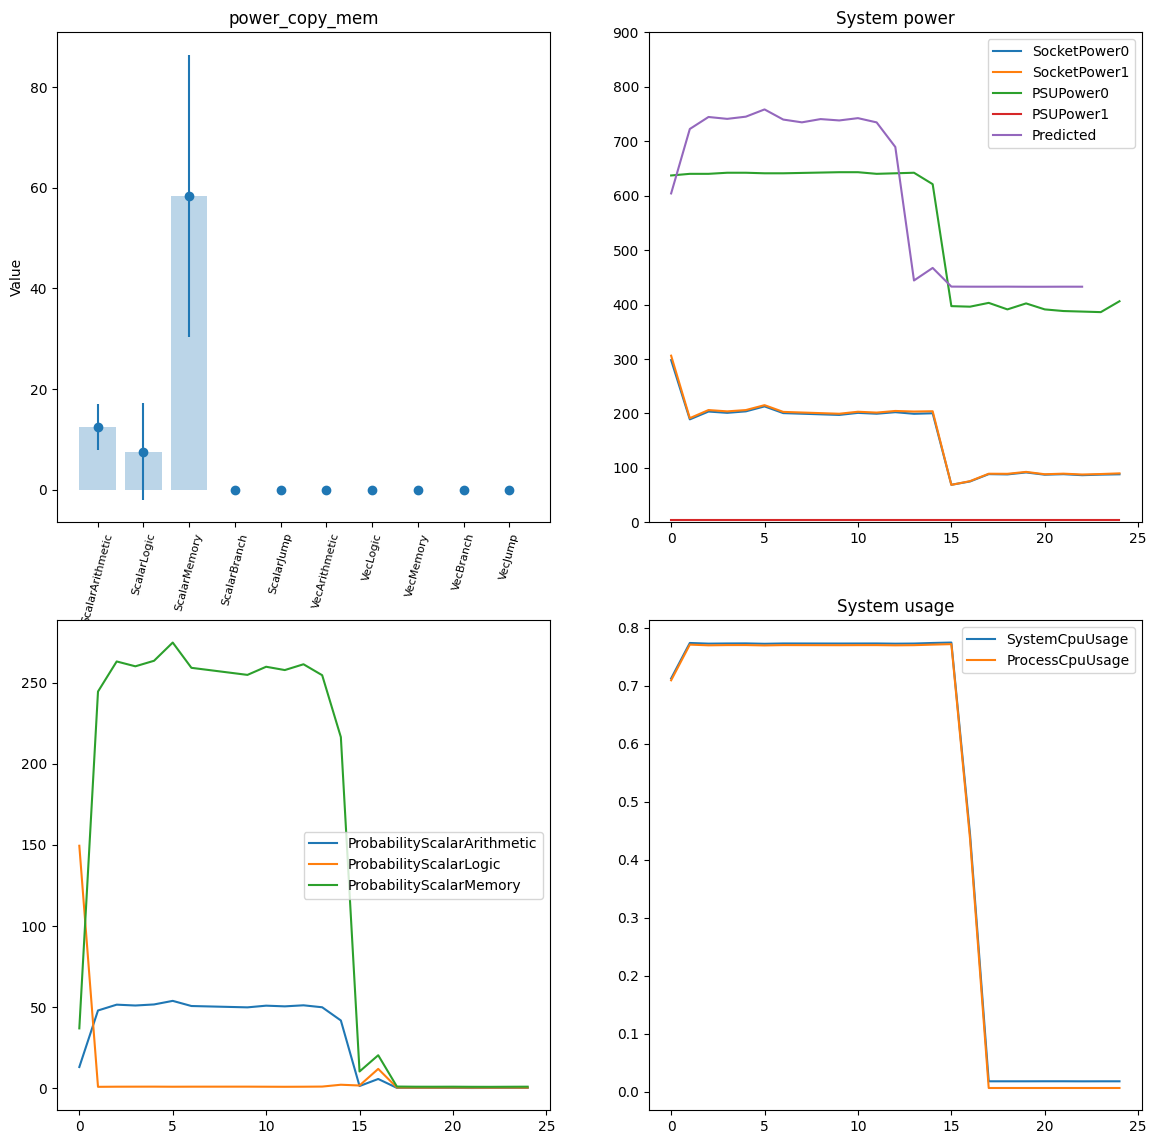

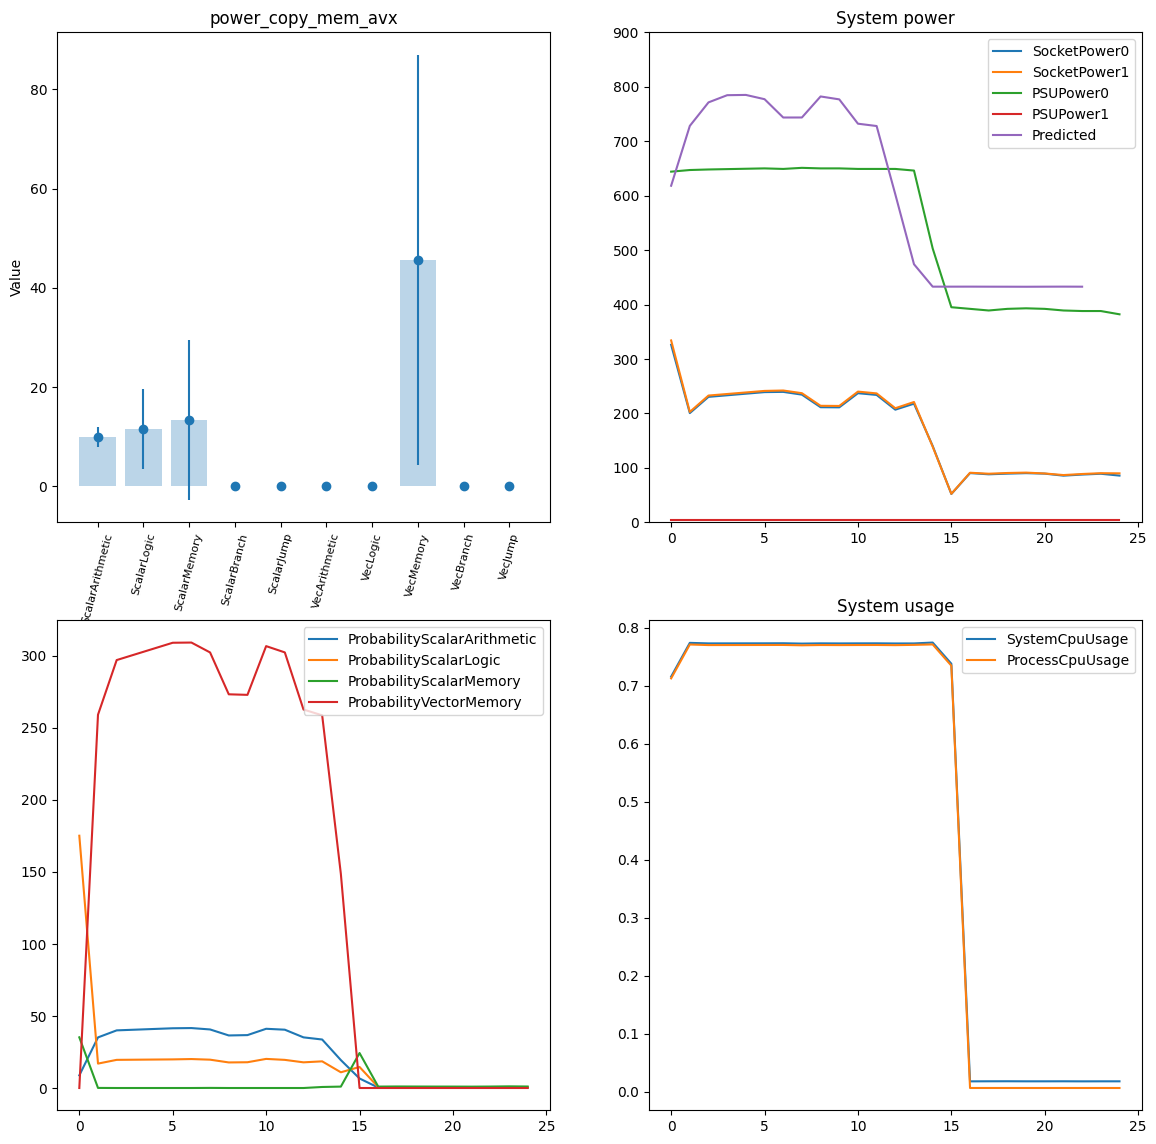

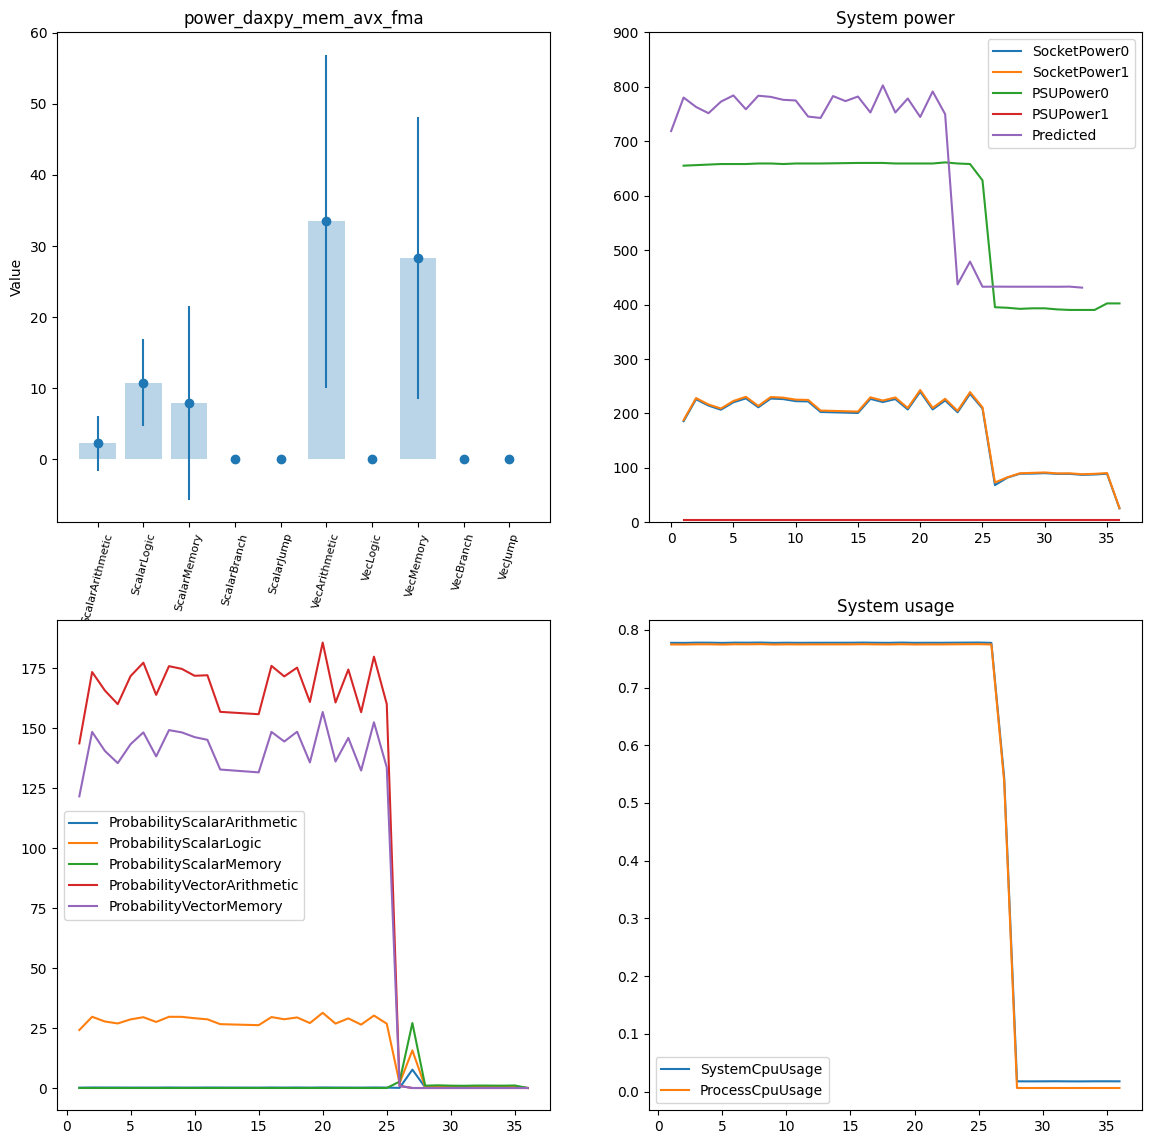

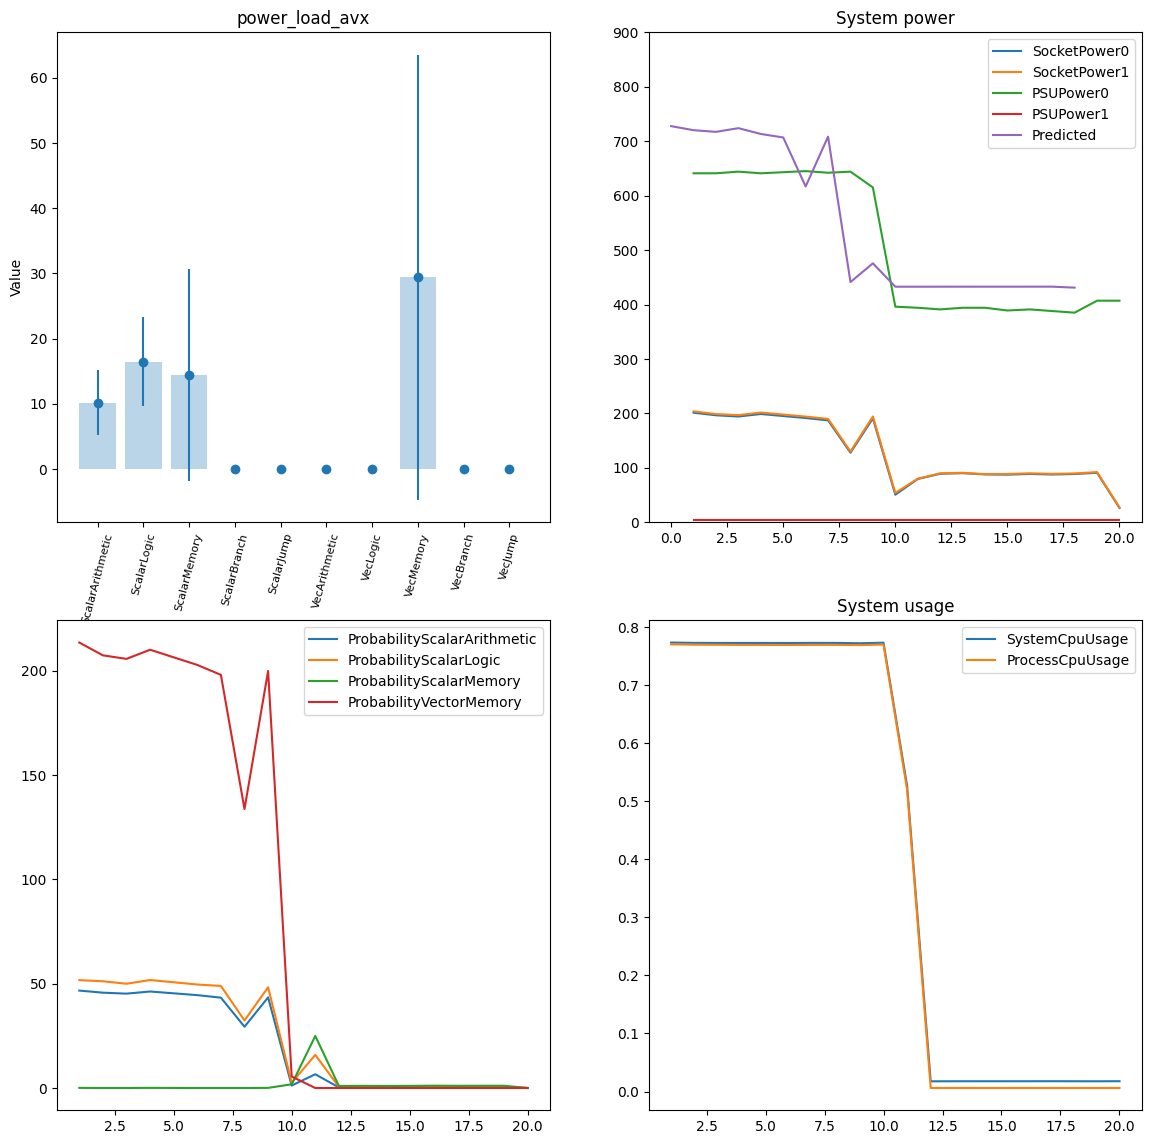

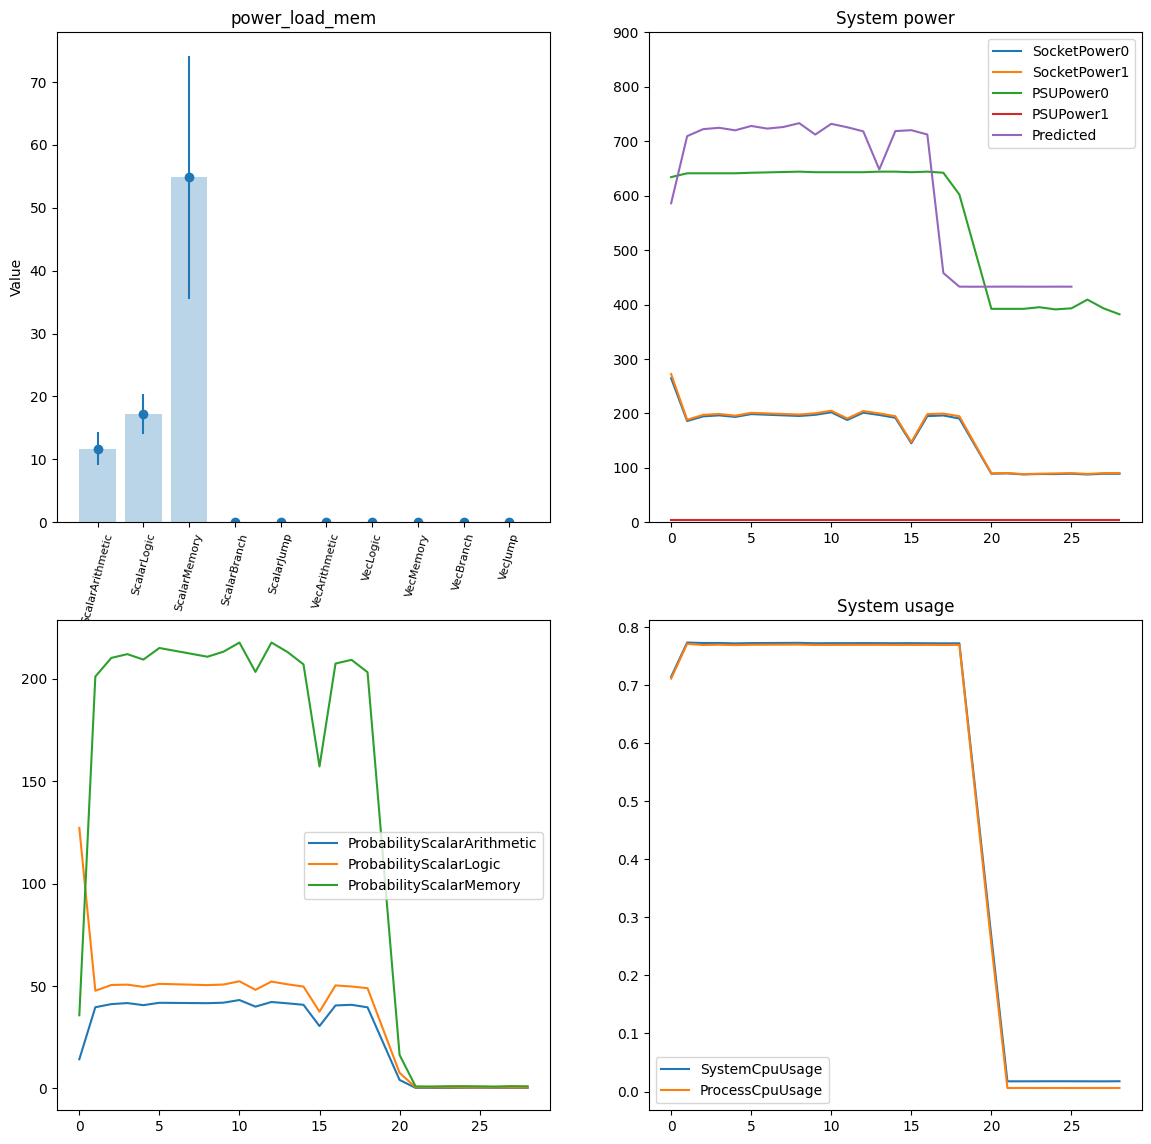

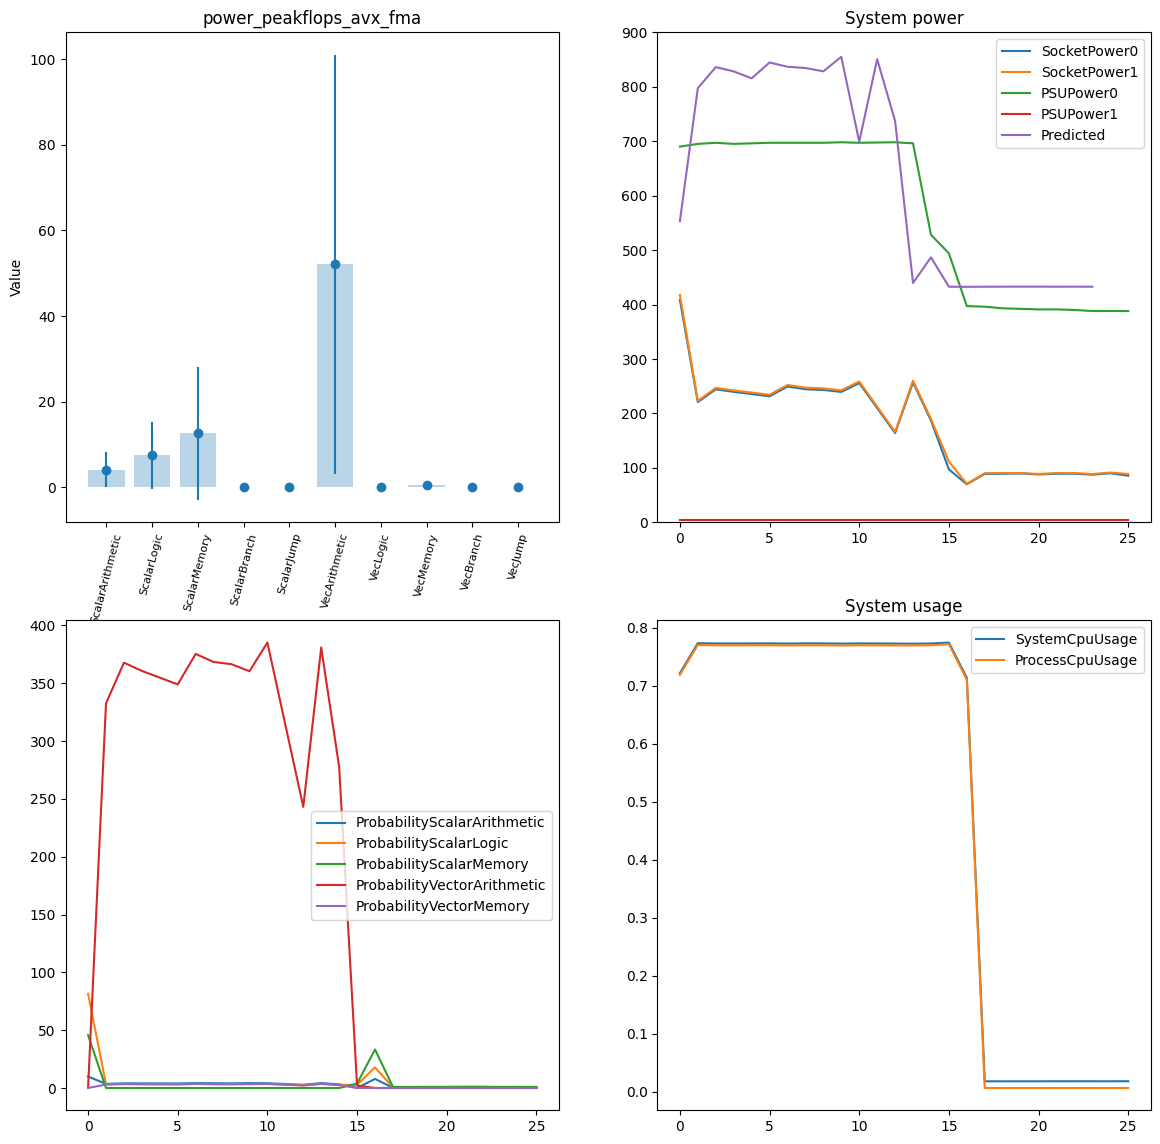

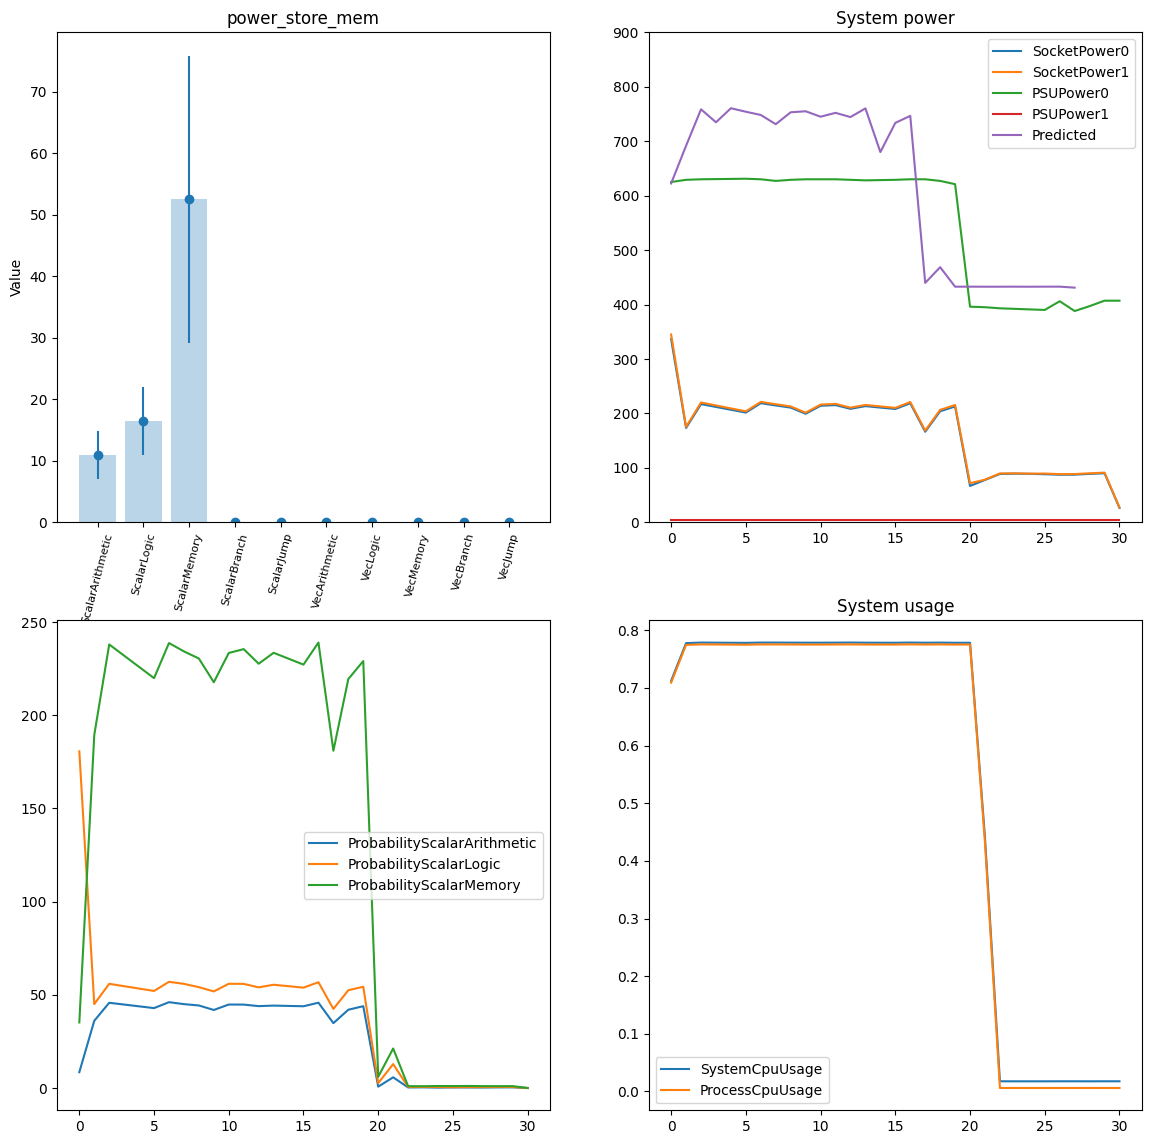

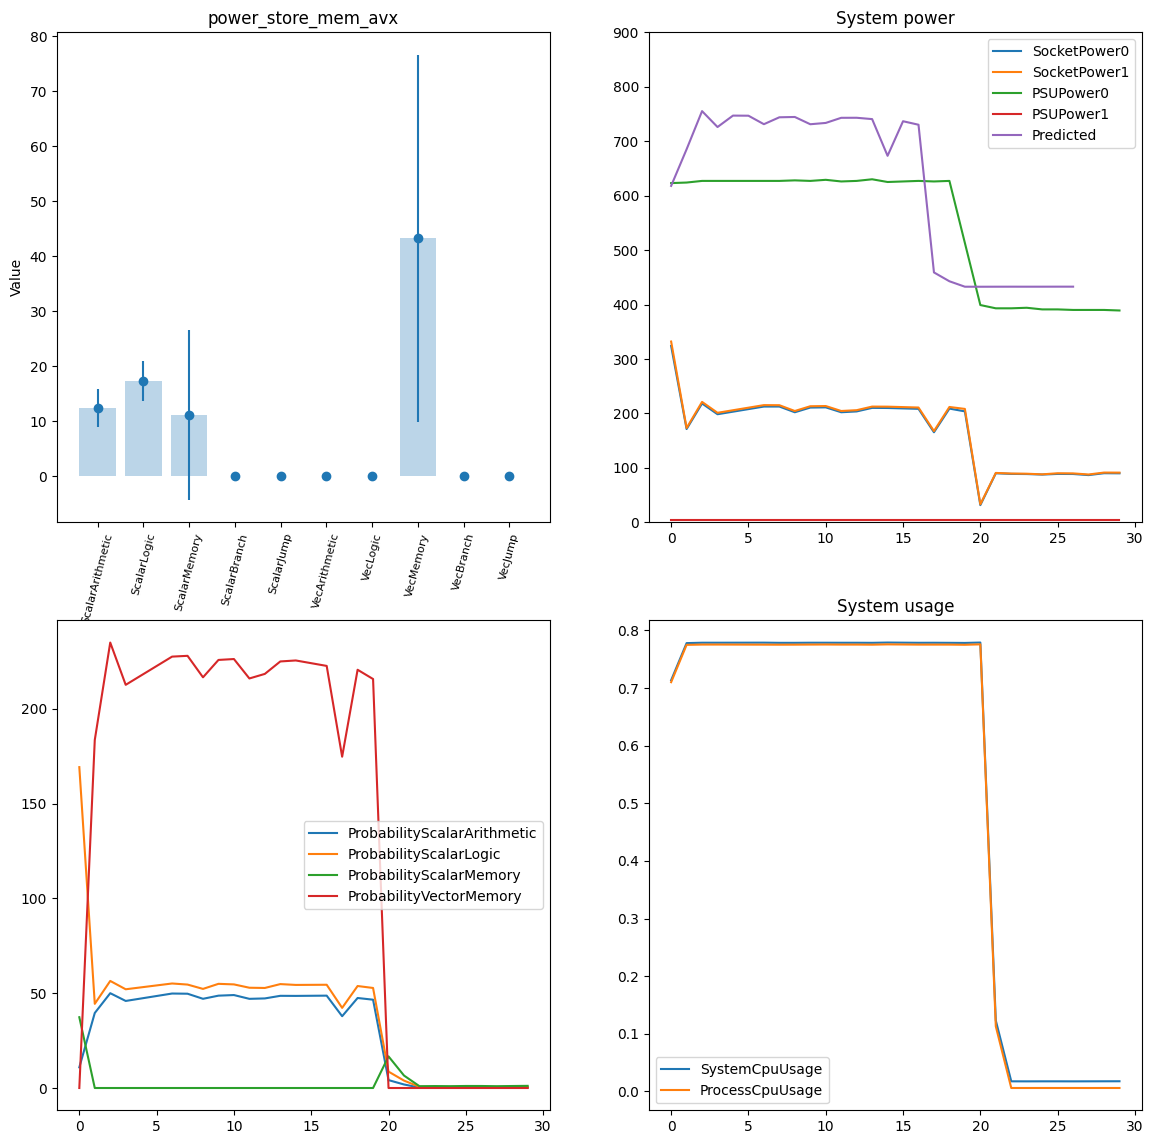

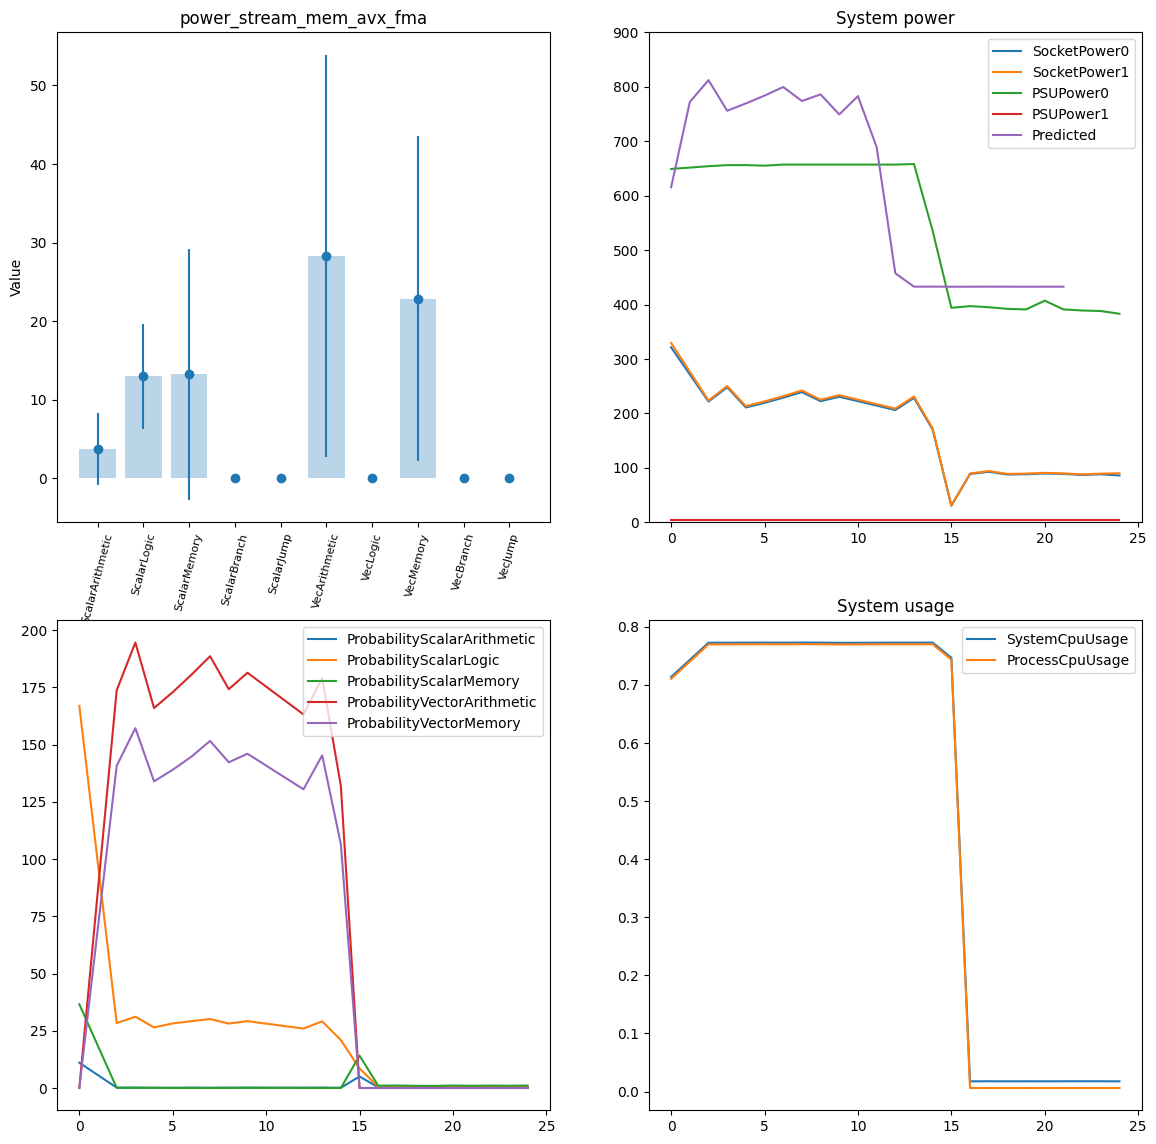

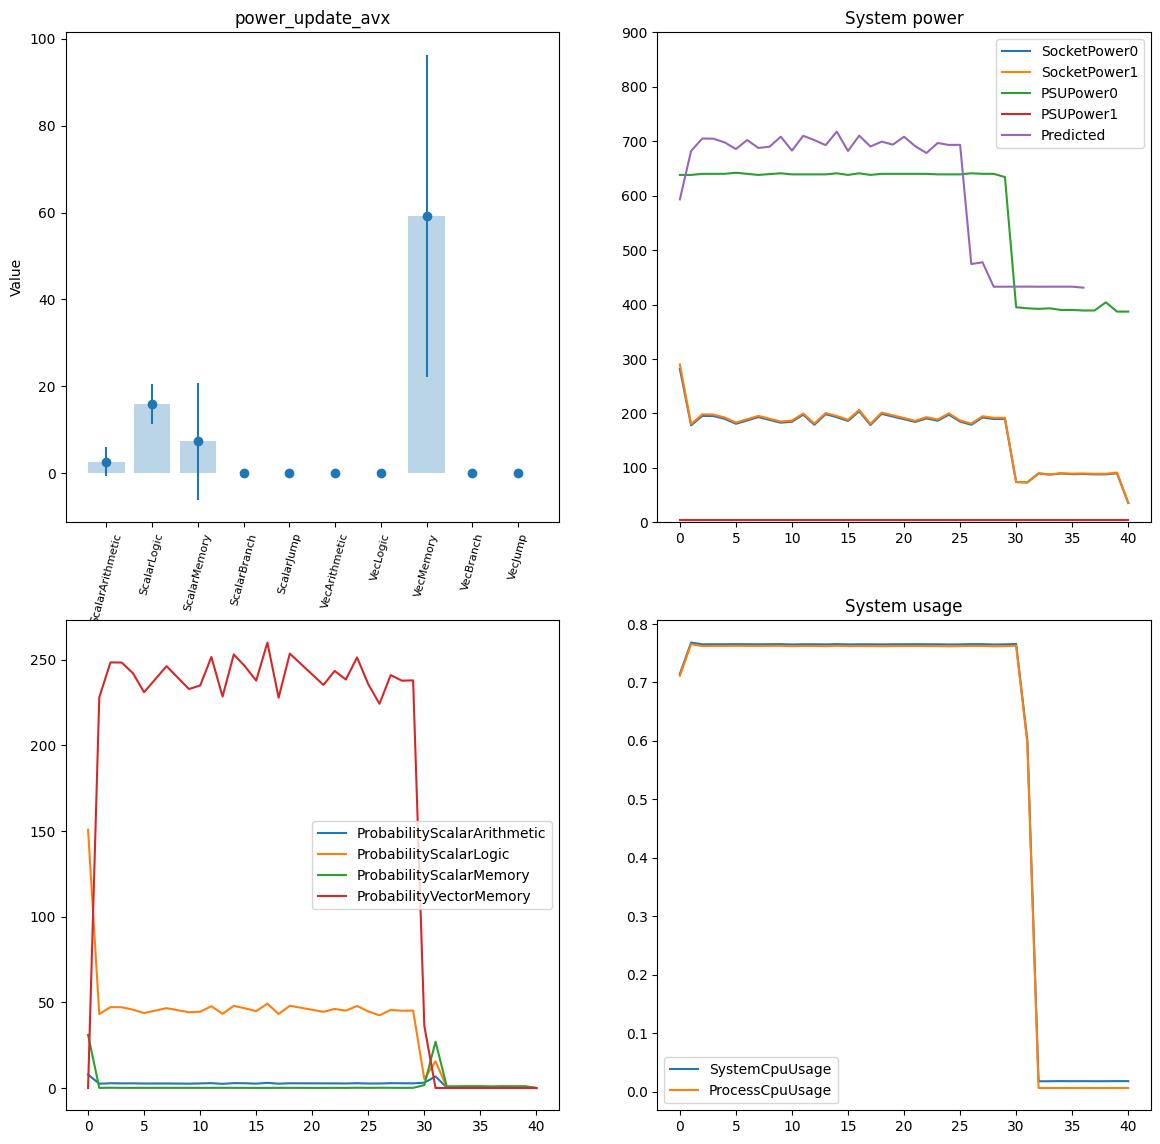

In [842]:
directory_list=["results_128"]

df_list=list()
for directory in directory_list:
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            try:
                df = pd.read_csv(os.path.join(directory, filename))
                df_list.append(df)
                print(f"Opened file: {filename}")
                #print(df.head())  # prints the first 5 rows of each CSV file
                plot(df,os.path.basename(filename).split(".")[0],coeff)
            except Exception as e:
                print(e)
